In [11]:
import json
import pandas as pd

# Load the characters.json file
file_path = "/Users/michelecoaro/Documents/GitHub/AOT_Network/Data/characters.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Drop unnecessary categories and keep only relevant attributes
filtered_data = []
for character in data:
    cleaned_character = {
        "id": character["id"],
        "name": character["name"],
        "alias": character.get("alias", []),
        "species": character.get("species", []),
        "groups": character.get("groups", []),
        "roles": character.get("roles", []),
        "episodes": character.get("episodes", [])
    }
    filtered_data.append(cleaned_character)

# Convert to a pandas DataFrame for easier manipulation
df_characters = pd.DataFrame(filtered_data)

# Display the cleaned DataFrame to the user
df_characters.head()

,id,name,alias,species,groups,roles,episodes
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


In [13]:
# Function to determine the season based on episode number
def assign_season(episodes):
    seasons = []
    for episode_url in episodes:
        # Extract the episode number from the URL
        episode_number = int(episode_url.split('/')[-1])
        # Assign the season based on the episode number
        if 1 <= episode_number <= 25:
            seasons.append(1)
        elif 26 <= episode_number <= 37:
            seasons.append(2)
        elif 38 <= episode_number <= 59:
            seasons.append(3)
        elif 60 <= episode_number <= 88:  # Dataset stops at episode 88
            seasons.append(4)
    return list(set(seasons))  # Remove duplicates since a character might span multiple seasons

# Add a 'seasons' column to the DataFrame
df_characters['seasons'] = df_characters['episodes'].apply(assign_season)

# Display the updated DataFrame to the user
df_characters.head()

,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


In [14]:
import networkx as nx

# Create a new graph object
G = nx.Graph()

# Create node lists for each layer
# Layer 1: Seasons
seasons = [1, 2, 3, 4]
G.add_nodes_from(seasons, layer="season")

# Layer 2: Characters
characters = df_characters["name"].tolist()
G.add_nodes_from(characters, layer="character")

# Layer 3: Episodes
# Extract unique episode numbers from the dataset
episodes = set()
for ep_list in df_characters["episodes"]:
    episodes.update([int(url.split('/')[-1]) for url in ep_list])
G.add_nodes_from(episodes, layer="episode")

# Create edges
# Season -> Character
for _, row in df_characters.iterrows():
    character_name = row["name"]
    for season in row["seasons"]:
        G.add_edge(season, character_name, type="season-character")

# Character -> Episode
for _, row in df_characters.iterrows():
    character_name = row["name"]
    episode_numbers = [int(url.split('/')[-1]) for url in row["episodes"]]
    for episode in episode_numbers:
        G.add_edge(character_name, episode, type="character-episode")

# Season -> Episode
for season in seasons:
    if season == 1:
        season_episodes = range(1, 26)
    elif season == 2:
        season_episodes = range(26, 38)
    elif season == 3:
        season_episodes = range(38, 60)
    elif season == 4:
        season_episodes = range(60, 89)  # Dataset ends at episode 88
    for episode in season_episodes:
        if episode in episodes:
            G.add_edge(season, episode, type="season-episode")

# Basic graph statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

{
    "Total Nodes": num_nodes,
    "Total Edges": num_edges,
    "Layers": {
        "Season Nodes": len(seasons),
        "Character Nodes": len(characters),
        "Episode Nodes": len(episodes),
    },
}


{'Total Nodes': 288,
 'Total Edges': 2626,
 'Layers': {'Season Nodes': 4, 'Character Nodes': 201, 'Episode Nodes': 88}}

In [15]:
#writing the graph so I can open it in GEPHI
nx.write_gexf(G, "AOT_Network.gexf")

In [17]:
# Update the graph for Gephi compatibility
# Convert 'type' to 'relationship' and set all edge types to 'UNDIRECTED'
for u, v, data in G.edges(data=True):
    # Move the 'type' attribute to 'relationship'
    data["relationship"] = data.pop("type", None)
    # Set the edge type to 'UNDIRECTED'
    data["type"] = "UNDIRECTED"

# Save the updated graph to a new GML file
nx.write_gml(G, "AOT_Network_gephi.gml")



In [18]:
# Ensure all nodes are properly tagged by layer and edges are correctly formed
# Reset the graph
G = nx.Graph()

# Add seasons as nodes with their layer tag
seasons = [1, 2, 3, 4]
G.add_nodes_from(seasons, layer="season")

# Add characters as nodes with their layer tag
characters = df_characters["name"].tolist()
G.add_nodes_from(characters, layer="character")

# Add episodes as nodes with their layer tag
episodes = set()
for ep_list in df_characters["episodes"]:
    episodes.update([int(url.split('/')[-1]) for url in ep_list])
G.add_nodes_from(episodes, layer="episode")

# Add edges between layers
# Season -> Episode
for season in seasons:
    if season == 1:
        season_episodes = range(1, 26)
    elif season == 2:
        season_episodes = range(26, 38)
    elif season == 3:
        season_episodes = range(38, 60)
    elif season == 4:
        season_episodes = range(60, 89)  # Dataset ends at episode 88
    for episode in season_episodes:
        if episode in episodes:
            G.add_edge(season, episode, type="season-episode")

# Character -> Episode
for _, row in df_characters.iterrows():
    character_name = row["name"]
    episode_numbers = [int(url.split('/')[-1]) for url in row["episodes"]]
    for episode in episode_numbers:
        G.add_edge(character_name, episode, type="character-episode")

# Re-export the updated graph for Gephi
nx.write_gml(G, "seasons_characters_episodes.gml")



In [20]:
# Reset the graph
G = nx.Graph()

# Add seasons as nodes with their layer tag
seasons = [1, 2, 3, 4]
G.add_nodes_from(seasons, layer="season", size=10)  # Default size for seasons

# Add characters as nodes with their layer tag and calculate size based on total appearances
characters = df_characters["name"].tolist()
character_sizes = (
    df_characters["episodes"]
    .apply(lambda eps: len(eps))  # Count the total appearances (episodes)
    .to_dict()
)
for idx, character in enumerate(characters):
    G.add_node(character, layer="character", size=character_sizes[idx])

# Add episodes as nodes with their layer tag
episodes = set()
for ep_list in df_characters["episodes"]:
    episodes.update([int(url.split('/')[-1]) for url in ep_list])
G.add_nodes_from(episodes, layer="episode", size=5)  # Default size for episodes

# Add edges between layers
# Season -> Episode
for season in seasons:
    if season == 1:
        season_episodes = range(1, 26)
    elif season == 2:
        season_episodes = range(26, 38)
    elif season == 3:
        season_episodes = range(38, 60)
    elif season == 4:
        season_episodes = range(60, 89)  # Dataset ends at episode 88
    for episode in season_episodes:
        if episode in episodes:
            G.add_edge(season, episode, type="season-episode")

# Character -> Episode
for _, row in df_characters.iterrows():
    character_name = row["name"]
    episode_numbers = [int(url.split('/')[-1]) for url in row["episodes"]]
    for episode in episode_numbers:
        G.add_edge(character_name, episode, type="character-episode")

# Re-export the updated graph for Gephi
output_file_with_sizes = "/mnt/data/tripartite_graph_with_sizes.gml"
nx.write_gml(G, "SIUUUUM.gml")



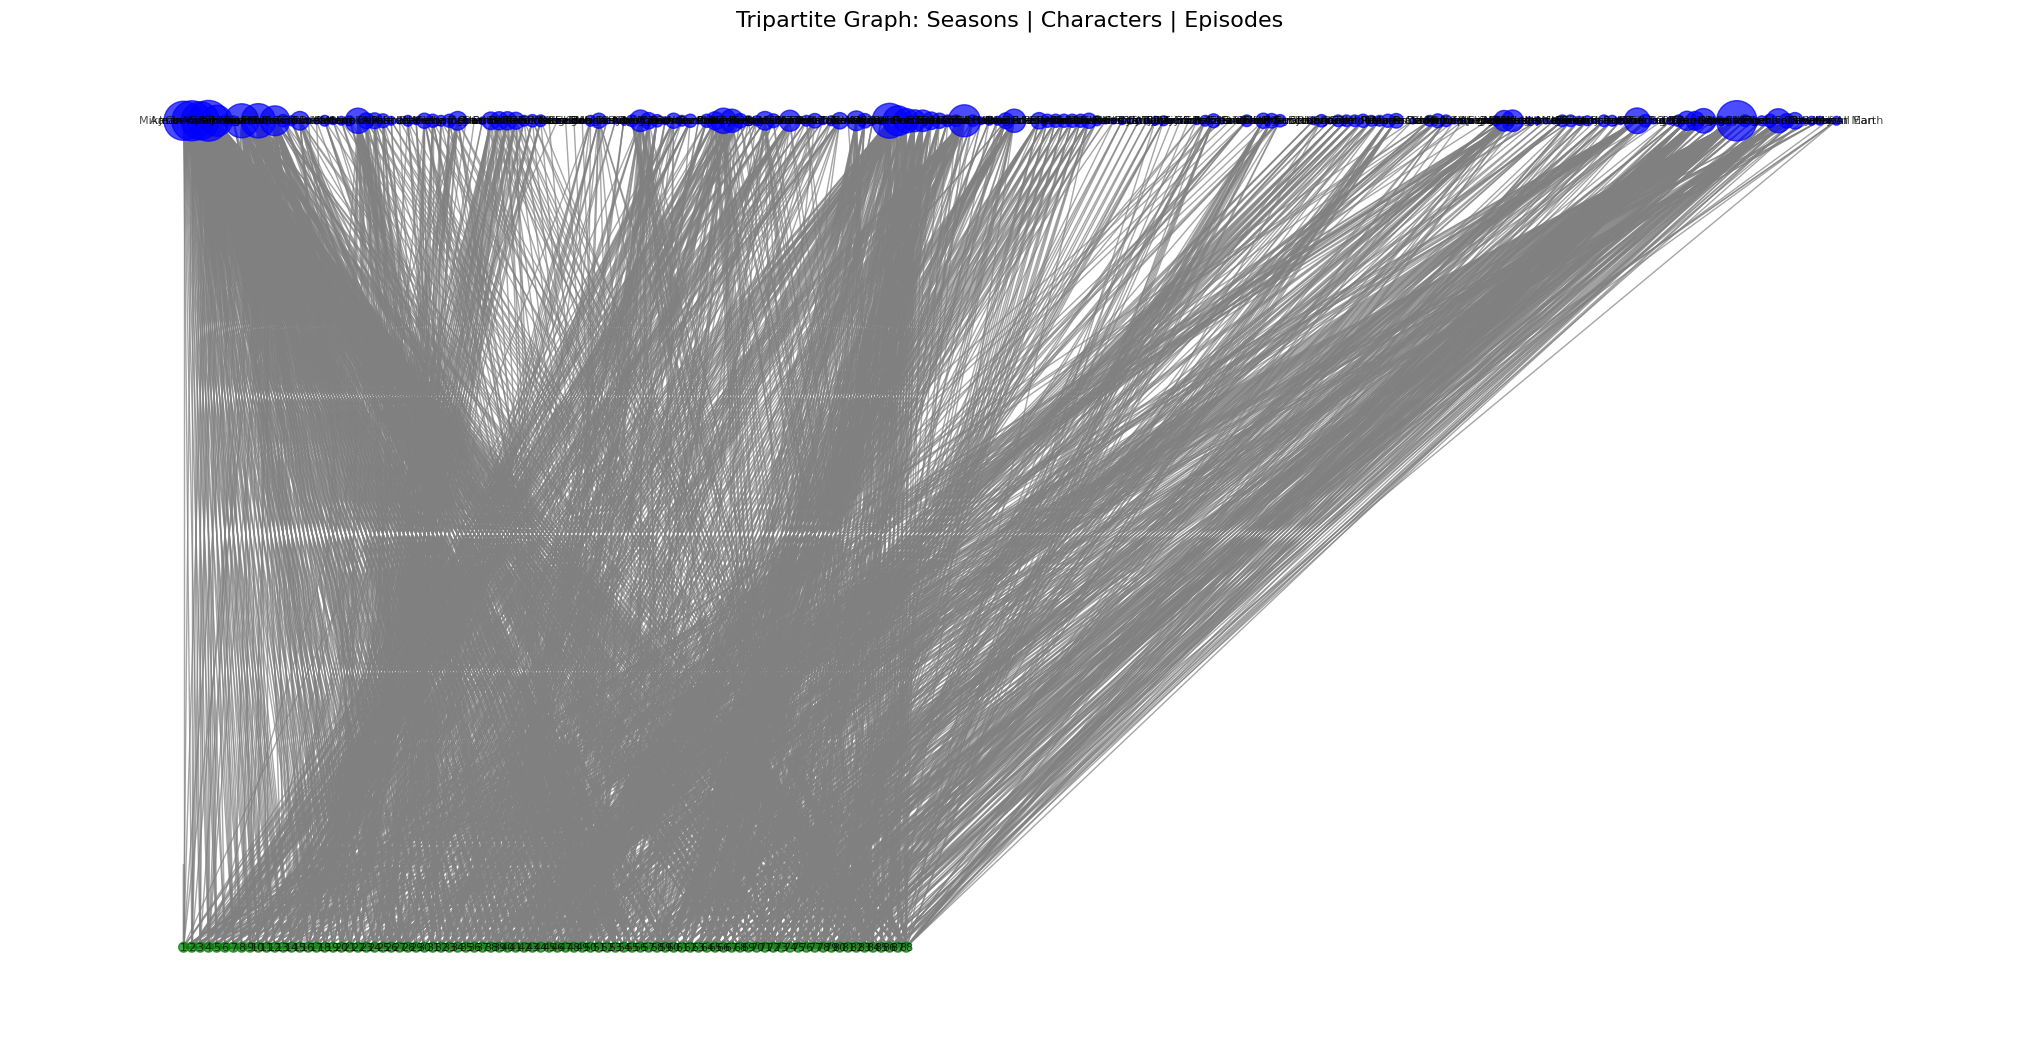

In [21]:
import matplotlib.pyplot as plt

# Define positions for the tripartite layout
pos = {}
# Assign positions for seasons (top layer)
for i, season in enumerate(seasons):
    pos[season] = (i, 3)

# Assign positions for characters (middle layer)
for i, character in enumerate(characters):
    pos[character] = (i, 2)

# Assign positions for episodes (bottom layer)
for i, episode in enumerate(sorted(episodes)):
    pos[episode] = (i, 1)

# Draw the graph
plt.figure(figsize=(20, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=[G.nodes[node]['size'] * 10 for node in G.nodes],
    node_color=[
        'red' if G.nodes[node]['layer'] == 'season'
        else 'blue' if G.nodes[node]['layer'] == 'character'
        else 'green'
        for node in G.nodes
    ],
    font_size=8,
    edge_color='gray',
    alpha=0.7,
)
plt.title("Tripartite Graph: Seasons | Characters | Episodes", fontsize=16)
plt.show()


In [24]:
def plot_season_graph_fixed(season, graph, season_episodes, characters, save=False):
    # Nodes for the subgraph
    subgraph_nodes = {season}
    subgraph_nodes.update(season_episodes)
    for char in characters:
        subgraph_nodes.add(char)
        graph.add_edge(season, char)  # Connect characters to the season

    # Create subgraph
    subgraph = graph.subgraph(subgraph_nodes)

    # Define positions for nodes
    pos = {}
    pos[season] = (0, 3)  # Position the season at the top
    for i, episode in enumerate(sorted(season_episodes)):  # Fix here
        pos[episode] = (i, 1)  # Episodes at the bottom
    for i, char in enumerate(characters):
        pos[char] = (i, 2)  # Characters in the middle

    # Draw the graph
    plt.figure(figsize=(12, 6))
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=[
            500 if graph.nodes[node].get("layer") == "season" else 200 for node in subgraph.nodes
        ],
        node_color=[
            "red" if graph.nodes[node].get("layer") == "season"
            else "blue" if graph.nodes[node].get("layer") == "character"
            else "green"
            for node in subgraph.nodes
        ],
        font_size=8,
        edge_color="gray",
        alpha=0.7,
    )
    plt.title(f"Graph for Season {season}", fontsize=14)
    if save:
        plt.savefig(f"season_{season}_graph_fixed.png")
    plt.show()


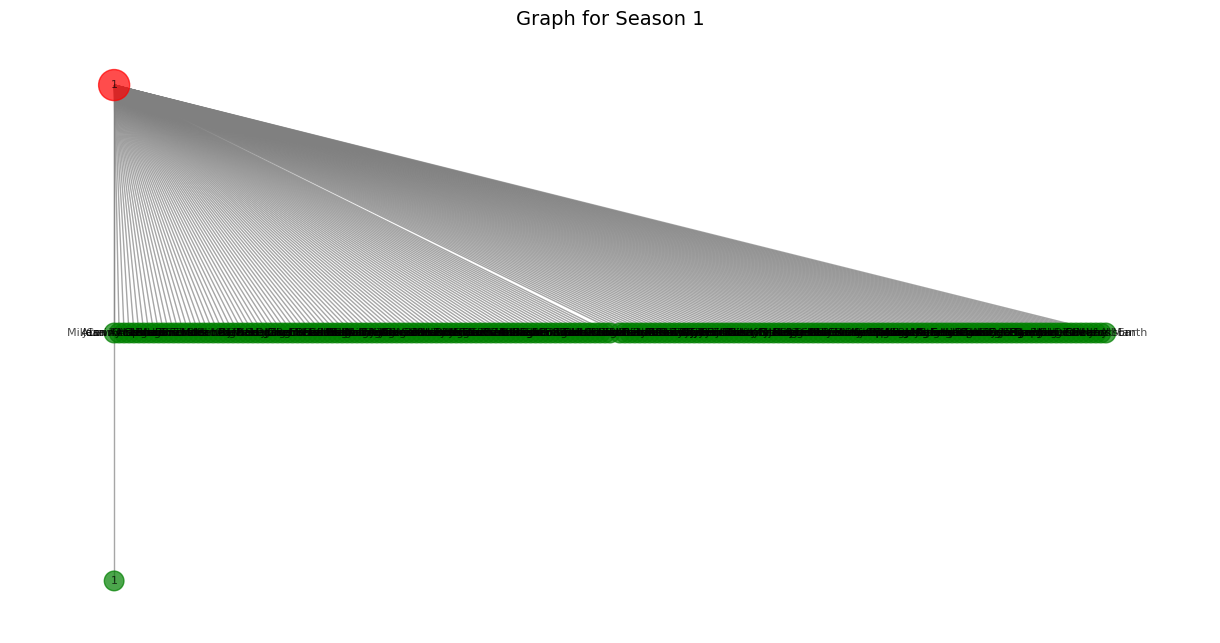

In [26]:
# Example of how the `plot_season_graph_fixed` function works

# Define an example graph with a simple structure
example_G = nx.Graph()

# Add example nodes and edges for Season 1
used_season = int(input("Insert the season you want to analyze: "))
used_episodes = input("Insert the episodes you want to analyze: ").split(", ")
# Add nodes with layers
example_G.add_node(used_season, layer="season")
for ep in used_episodes:
    example_G.add_node(ep, layer="episode")
    example_G.add_edge(used_season, ep, type="season-episode")

# Use the function to plot for Season 1
plot_season_graph_fixed(used_season, example_G, used_episodes, characters, save=False)
